# Histogramm: Radar -Lidar

## Imports

In [1]:
%matplotlib inline
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import numpy.ma as ma
from matplotlib.colors import ListedColormap
from datetime import datetime, timedelta
import matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import os
import math
from datetime import datetime, timedelta

In [2]:
from RadarLidarWindSpeed import RadarLidarWindSpeed

In [3]:
dateBegin = datetime(2020, 7, 1)
dateEnd = datetime(2020, 7, 31)
analysis = RadarLidarWindSpeed(dateBegin, dateEnd)
analysis.importDataset()
analysis.calculateDifferences()

In [4]:
minHeight = 0
maxHeight = 15000
days = np.arange(dateBegin, dateEnd, timedelta(days=1)).astype(datetime)
hours = np.arange(dateBegin, dateEnd, timedelta(hours=0.5)).astype(datetime)

minHeightIndex = int(minHeight/50)
maxHeightIndex = int(maxHeight/50)
steps = (maxHeightIndex - minHeightIndex)
heightGrid = list(range(0,15000,50))
heightGridDf = pd.DataFrame({'height': heightGrid})
def mergeHeight(heightList):
    # map height
    knn = NearestNeighbors(n_neighbors=1)
    knn.fit(heightList)
    return knn.kneighbors(heightGridDf, return_distance=False)

gridTimeSeries = []
for entry in hours:
    gridTimeSeries.append(datetime.timestamp(entry))
gridDf = pd.DataFrame({'time': gridTimeSeries})  
def timeknn(TimeSeries):
    #Target Grid
    targetTimeList = []
    for entry in TimeSeries:
        stamp = (entry-2440587.5)*86400
        targetTimeList.append(stamp)
    targetDf = pd.DataFrame({'time': targetTimeList})
    
    #KNN
    knn = NearestNeighbors(n_neighbors=1)
    knn.fit(targetDf)
    matchList = knn.kneighbors(gridDf, return_distance=True)
    

    #generate result
    resultList = []
    for i in range(len(gridTimeSeries)):
        iMatch = int(matchList[1][i])
        if matchList[0][i] <= 60*14: #14 Minuten
            resultList.append(iMatch)
        else:
            resultList.append(np.nan)
    return resultList

difference = []
def readFile(n, pathRadar, pathLidar):
    #Radar
    if os.path.exists(pathRadar):
        datasetRadar = Dataset(pathRadar, mode='r')
        heightRadar = datasetRadar.variables['height'][:]
        heightRadarDf = pd.DataFrame({'height': heightRadar})
        speedRadar = datasetRadar.variables['speed'][:]
        speedRadar = speedRadar.filled(np.nan)
        timeRadar = datasetRadar.variables['time'][:]
        speedRadar = speedRadar.T
        matchRadarIndex = mergeHeight(heightRadarDf)
        matchRadarTimeIndex = timeknn(timeRadar)
    #Lidar
    if os.path.exists(pathLidar):
        datasetLidar = Dataset(pathLidar, mode='r')
        heightLidar = datasetLidar.variables['height'][:]
        heightLidarDf = pd.DataFrame({'height': heightLidar})
        speedLidar = datasetLidar.variables['speed'][:]
        speedLidar = speedLidar.filled(np.nan)
        timeLidar = datasetLidar.variables['time'][:]
        matchLidarIndex = mergeHeight(heightLidarDf)
        matchLidarTimeIndex = timeknn(timeLidar)
    if os.path.exists(pathLidar) and os.path.exists(pathRadar):
        for nHour in range(len(hours)):
            for i in range(minHeightIndex,maxHeightIndex):
                iMatchRadar = matchRadarIndex[i]
                nMatchRadar = matchRadarTimeIndex[nHour]
                iMatchLidar = matchLidarIndex[i]
                nMatchLidar = matchLidarTimeIndex[nHour]
                if not math.isnan(iMatchRadar) and not math.isnan(iMatchLidar):
                    if not math.isnan(nMatchRadar) and not math.isnan(nMatchLidar):
                        if not math.isnan(speedRadar[iMatchRadar,nMatchRadar]) and not math.isnan(speedLidar[iMatchLidar,nMatchLidar]):
                            difference.append(float(speedRadar[iMatchRadar,nMatchRadar]-speedLidar[iMatchLidar,nMatchLidar]))
for n in range(len(days)):
    day = days[n]
    pathRadar = '/data/obs/site/jue/joyrad35/wind_ppi/data/'+day.strftime("%Y")+'/'+day.strftime("%m")+'/'+day.strftime("%Y%m%d")+'_joyrad35_wind_profile.nc'
    pathLidar = '/data/obs/site/jue/wind_lidar/l1/'+day.strftime("%Y")+'/'+day.strftime("%m")+'/'+day.strftime("%d")+'/wind_vad-36_'+day.strftime("%Y%m%d")+'.nc'
    readFile(n,pathRadar, pathLidar)
array = np.array(difference)
np.clip(array,-20,20,out=array)
mu = array.mean()
median = np.median(array)
sigma = np.std(array)

## Plot

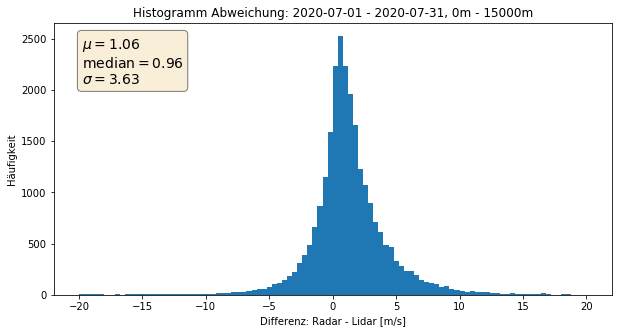

In [5]:
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
fig, ax = plt.subplots(figsize=(10, 5))

plt.title("Histogramm Abweichung: "+dateBegin.strftime("%Y-%m-%d")+" - "+dateEnd.strftime("%Y-%m-%d")+", "+str(minHeight)+"m - "+str(maxHeight)+"m")
plt.xlabel("Differenz: Radar - Lidar [m/s]")
plt.ylabel("Häufigkeit")
ax.hist(difference, range=[-20,20],bins=100)

# place a text box in upper left in axes coords
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

plt.savefig('histogramm_'+str(minHeight)+'_'+str(maxHeight)+'.png')
plt.show()

In [14]:
diffs = analysis.dataframe['speedDifference'].tolist()
diffs = [x for x in diffs if str(x) != 'nan']
len(difference)

25448

In [10]:
minHeight = 0
maxHeight = 15000
diffs = analysis.dataframe['speedDifference'].tolist()
diffs = [x for x in diffs if str(x) != 'nan']
array = np.array(diffs)
np.clip(array,-20,20,out=array)
mu = array.mean()
median = np.median(array)
sigma = np.std(array)

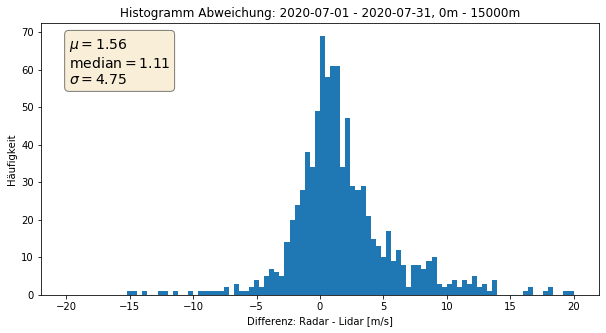

In [11]:
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
fig, ax = plt.subplots(figsize=(10, 5))

plt.title("Histogramm Abweichung: "+dateBegin.strftime("%Y-%m-%d")+" - "+dateEnd.strftime("%Y-%m-%d")+", "+str(minHeight)+"m - "+str(maxHeight)+"m")
plt.xlabel("Differenz: Radar - Lidar [m/s]")
plt.ylabel("Häufigkeit")
ax.hist(diffs, range=[-20,20],bins=100)

# place a text box in upper left in axes coords
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

plt.savefig('histogramm_'+str(minHeight)+'_'+str(maxHeight)+'.png')
plt.show()